In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import pickle

import matplotlib.pyplot as plt

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector,StrVector
from rpy2.robjects import pandas2ri,numpy2ri
pandas2ri.activate()
from rpy2 import robjects

from tqdm import *

import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

import networkx as nx

In [2]:
##
## Define utility functions
##

# jaccard similarity for pathway clustering
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)

# gmt processing functions
def enrichments_to_custom_dict(enrichments_frame, original_dict, top_genes_frame, actual_genes=True):
    
    custom_dict = {}
    
    for term in enrichments_frame.term_description:
        
        modified_term = 'GO_'+term.upper().replace(' ','_')
        
        if modified_term in original_dict.keys():
            if actual_genes == True:
                custom_list = []
                for gene in original_dict[modified_term]:
                    if gene in top_genes_frame.genes.values:
                        custom_list.append(gene)
                custom_dict[modified_term] = custom_list
            else:
                custom_dict[modified_term] = original_dict[modified_term]
                
                
    return custom_dict

def gmt_to_dict(dict_dir):
    with open(dict_dir) as genesets:
        read_dict = { line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                      for line in genesets.readlines()}
    return read_dict

In [3]:
##
## Load Venetoclax Interaction Matrix
##

venim = pickle.load(open('../data/interaction_matrices/' + "Venetoclax" + '.p','rb'))

In [4]:
##
## Load Features
##

DATADIR = '../data/'

X_drug_labels = pickle.load(open(DATADIR+'X_drug_labels_train.p','rb'))
X_drug_targets = pickle.load(open(DATADIR+'X_drug_targets_train.p','rb'))
X_rna_seq_full = pickle.load(open(DATADIR+'X_rna_seq_full_train.p','rb'))

X = pd.concat([X_drug_labels,X_drug_targets,X_rna_seq_full],axis = 1)

In [5]:
##
## Calculate the average magnitude interactions of each gene expression feature
## with the venetoclax label and sort gene expression features by that average mag.
##
ma_venetoclax = np.mean(np.abs(venim[:,158:]),axis=0)

corr_frame = pd.DataFrame(index=list(X_rna_seq_full))
corr_frame['shap'] = ma_venetoclax
    
venetoclax_frame = corr_frame.fillna(0).sort_values('shap',ascending=False)

In [6]:
## import string_db from r
## and define functions

STRINGdb = importr('STRINGdb')
robjects.r('''
        string_db <- STRINGdb$new( version="10", species=9606,score_threshold=400, input_directory="" )
        ''')
robjects.r('''
        get_mapped_frame <- function(input) {
            return(string_db$map( input , "genes", removeUnmappedRows = TRUE ))
        }
        ''')
robjects.r('''
        return_enrichments <- function(input) {
            return(string_db$get_enrichment(input, category = "Process", methodMT = "fdr", iea = TRUE, minScore=NULL))
        }
        ''')

R object with classes: ('function',) mapped to:

In [7]:
# Calculate enrichments in the top genes

n_genes = 500
    
print('Getting results for top {:d} genes'.format(n_genes))
top = venetoclax_frame.iloc[:n_genes,:]

top_500 = pd.DataFrame()
top_500['genes'] = top.index
top_500['shap'] = top['shap'].values

with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(top_500)
    mapped_frame = robjects.r['get_mapped_frame'](top_500)

    enrichments = robjects.r['return_enrichments'](mapped_frame.iloc[:,2])
    with localconverter(ro.default_converter + pandas2ri.converter):
        py_enrichments = ro.conversion.rpy2py(enrichments)

Getting results for top 500 genes


R[write to console]: trying URL 'http://string.uzh.ch/permanent/string/10/protein_aliases/9606__protein_aliases_tf.tsv.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 13939907 bytes (13.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

R[write to console]: trying URL 'http://string.uzh.ch/permanent/string/10/enrichment_annotations/annotations/annotations_9606.tsv.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 26525329 bytes (25.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [8]:
# filter to only consider significant enrichments

sig_enrichments = py_enrichments[py_enrichments.pvalue_fdr < 0.05]
c5_dict = gmt_to_dict('../data/c5.all.v6.2.symbols.gmt')
venetoclax_sig_enrichment_dict = enrichments_to_custom_dict(sig_enrichments,c5_dict,top_500)
sig_pathways = list(venetoclax_sig_enrichment_dict.keys())

In [9]:
# create an adjacency matrix for clustering pathways based on jaccard similarity
adjacency_frame = pd.DataFrame(index=sig_pathways,columns=sig_pathways).fillna(0.)

for pathway_1 in adjacency_frame.index:
    for pathway_2 in adjacency_frame.index:
        if pathway_1 != pathway_2:
            adjacency_frame.loc[pathway_1,pathway_2] = jaccard_similarity(venetoclax_sig_enrichment_dict[pathway_1], venetoclax_sig_enrichment_dict[pathway_2])

In [10]:
# rename terms
sig_enrichments['term_modified'] = ['GO_'+term.upper().replace(' ','_') for term in sig_enrichments.term_description]

<ipython-input-10-a025741cfb3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_enrichments['term_modified'] = ['GO_'+term.upper().replace(' ','_') for term in sig_enrichments.term_description]


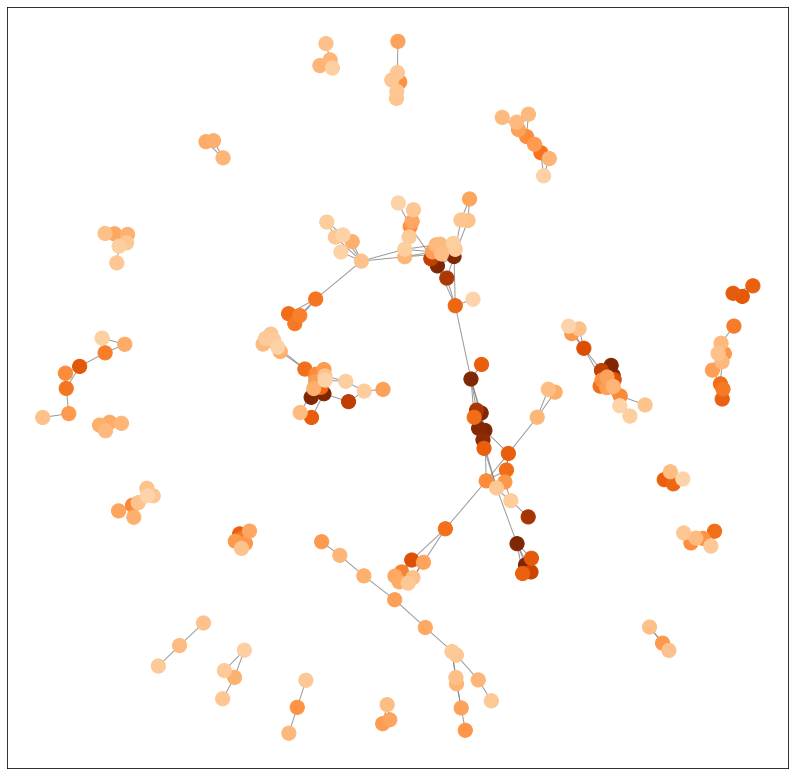

In [11]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### filter connections to only be between pathways with greater than 0.4 jaccard similarity
filter_slice = adjacency_frame.values < 0.4
adjacency_frame[filter_slice] = 0

### make graph
G = nx.from_numpy_matrix(adjacency_frame.values)
### remove unconnected nodes
remove_list = []
for x in nx.connected_components(G):
    if(len(x)) < 3:
        for node in x:
            remove_list.append(node)
# G.remove_nodes_from(list(nx.isolates(G)))
G.remove_nodes_from(remove_list)

### different edge weights?
# elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.75]
# esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.75]

### make layout
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
fig = plt.figure(figsize=(14,14))
labels = {}
for i in range(len(list(adjacency_frame))):
    labels[i] = list(adjacency_frame.index.values)[i]
    
node_nlt_qvals = [-1.*np.log10(sig_enrichments[sig_enrichments.term_modified == adjacency_frame.columns[node]].pvalue_fdr.values[0]) for node in G.nodes()]
    
nx.draw_networkx_nodes(G, pos, node_size=200, cmap=plt.get_cmap('Oranges'), node_color=node_nlt_qvals,vmin=0.5,vmax=4)
# nx.draw_networkx_labels(G,pos,labels,font_size=4)

# edges
nx.draw_networkx_edges(G, pos, width=1, alpha=0.8, edge_color='gray')
# nx.draw_networkx_edges(G, pos, edgelist=elarge,edge_color='blue',
#                        width=2)
# nx.draw_networkx_edges(G, pos, edgelist=esmall,
#                        width=1, alpha=0.8, edge_color='gray', style='dashed')

# with PdfPages('../data/venetoclax_interaction_pathway_graph.pdf') as pdf:
#     pdf.savefig()

plt.show()